# Customizing transpilation

## Working with preset pass managers

Qiskit includes functions to build preset [`PassManager`](/api/qiskit/qiskit.transpiler.PassManager) objects.
These preset passmanagers are used by the [`transpile`](/api/qiskit/qiskit.utils.QuantumInstance#transpile) function
for each optimization level. There are 4 optimization levels ranging from 0 to 3, where higher
optimization levels take more time and computational effort but may yield a
more optimal circuit.
Optimization level 0 is intended for device characterization experiments and, as such, only
maps the input circuit to the constraints of the target backend, without
performing any optimizations. Optimization level 3 spends the most effort to optimize the circuit.
However, as many of the optimization techniques in the transpiler are heuristic based, spending more
computational effort does not always result in an improvement in the quality of the output
circuit.

If you'd like to work directly with a
preset pass manager you can use the [`generate_preset_pass_manager`](/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager)
function to easily generate one. For example, the following code generates a [`StagedPassManager`](/api/qiskit/qiskit.transpiler.StagedPassManager) object for optimization level 3
targeting the `ibm_brisbane` backend (equivalent to what is used internally
by `transpile` with `optimization_level=3`).

In [1]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
pass_manager = generate_preset_pass_manager(3, backend)

## Creating your own pass manager

The [qiskit.transpiler.passes](/api/qiskit/transpiler_passes) module includes many transpiler passes that you can use to to create your own pass managers. To create your own pass manager, simply initialize a `PassManager` with a list of passes. For example, the following code creates a transpiler pass that merges adjacent two-qubit gates and then synthesizes them into a basis of [$R_y$](https://docs.quantum-computing.ibm.com/api/qiskit/qiskit.circuit.library.RYGate), [$R_z$](https://docs.quantum-computing.ibm.com/api/qiskit/qiskit.circuit.library.RZGate), and [$R_{xx}$](https://docs.quantum-computing.ibm.com/api/qiskit/qiskit.circuit.library.RXXGate),  gates.

In [2]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    ConsolidateBlocks,
    UnitarySynthesis,
)

basis_gates = ["rx", "ry", "rxx"]
translate = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates),
    ]
)

### Creating a pass manager for dynamical decoupling

Here, we show how to use the [`PadDynamicalDecoupling`](/api/qiskit/qiskit.transpiler.passes.PadDynamicalDecoupling) pass to add an error suppression technique called _dynamical decoupling_ to the circuit. Because this pass only operates on scheduled circuits and involves gates that are not necessarily basis gates of our target, we will need the [`ALAPScheduleAnalysis`](/api/qiskit/qiskit.transpiler.passes.ALAPScheduleAnalysis) and [`BasisTranslator`](/api/qiskit/qiskit.transpiler.passes.BasisTranslator) passes as well.

We will work with the `ibm_brisbane` that we initialized earlier on this page. We get the `target` information from the `backend` and save the operation names as `basis_gates` because we will need to modify the `target` to add timing information for the gates used in dynamical decoupling.

In [3]:
target = backend.target
basis_gates = list(target.operation_names)

We'll create an `EfficientSU2` circuit as an example. We'll first transpile the circuit to the backend because dynamical decoupling pulses need to be added after the circuit has been transpiled and scheduled. Dynamical decoupling often works best when there is a lot of idle time in the quantum circuits. That is, there are qubits that are not being used while others are active. We can see this is the case in this circuit because the two-qubit `ecr` gates are applied sequentially in this ansatz.

/home/kjs/.local/share/virtualenvs/documentation--fuetTj0/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:282: UserWarning: Style JSON file 'iqp.json' not found in any of these locations: /home/kjs/.local/share/virtualenvs/documentation--fuetTj0/lib/python3.10/site-packages/qiskit/visualization/circuit/styles/iqp.json, iqp.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


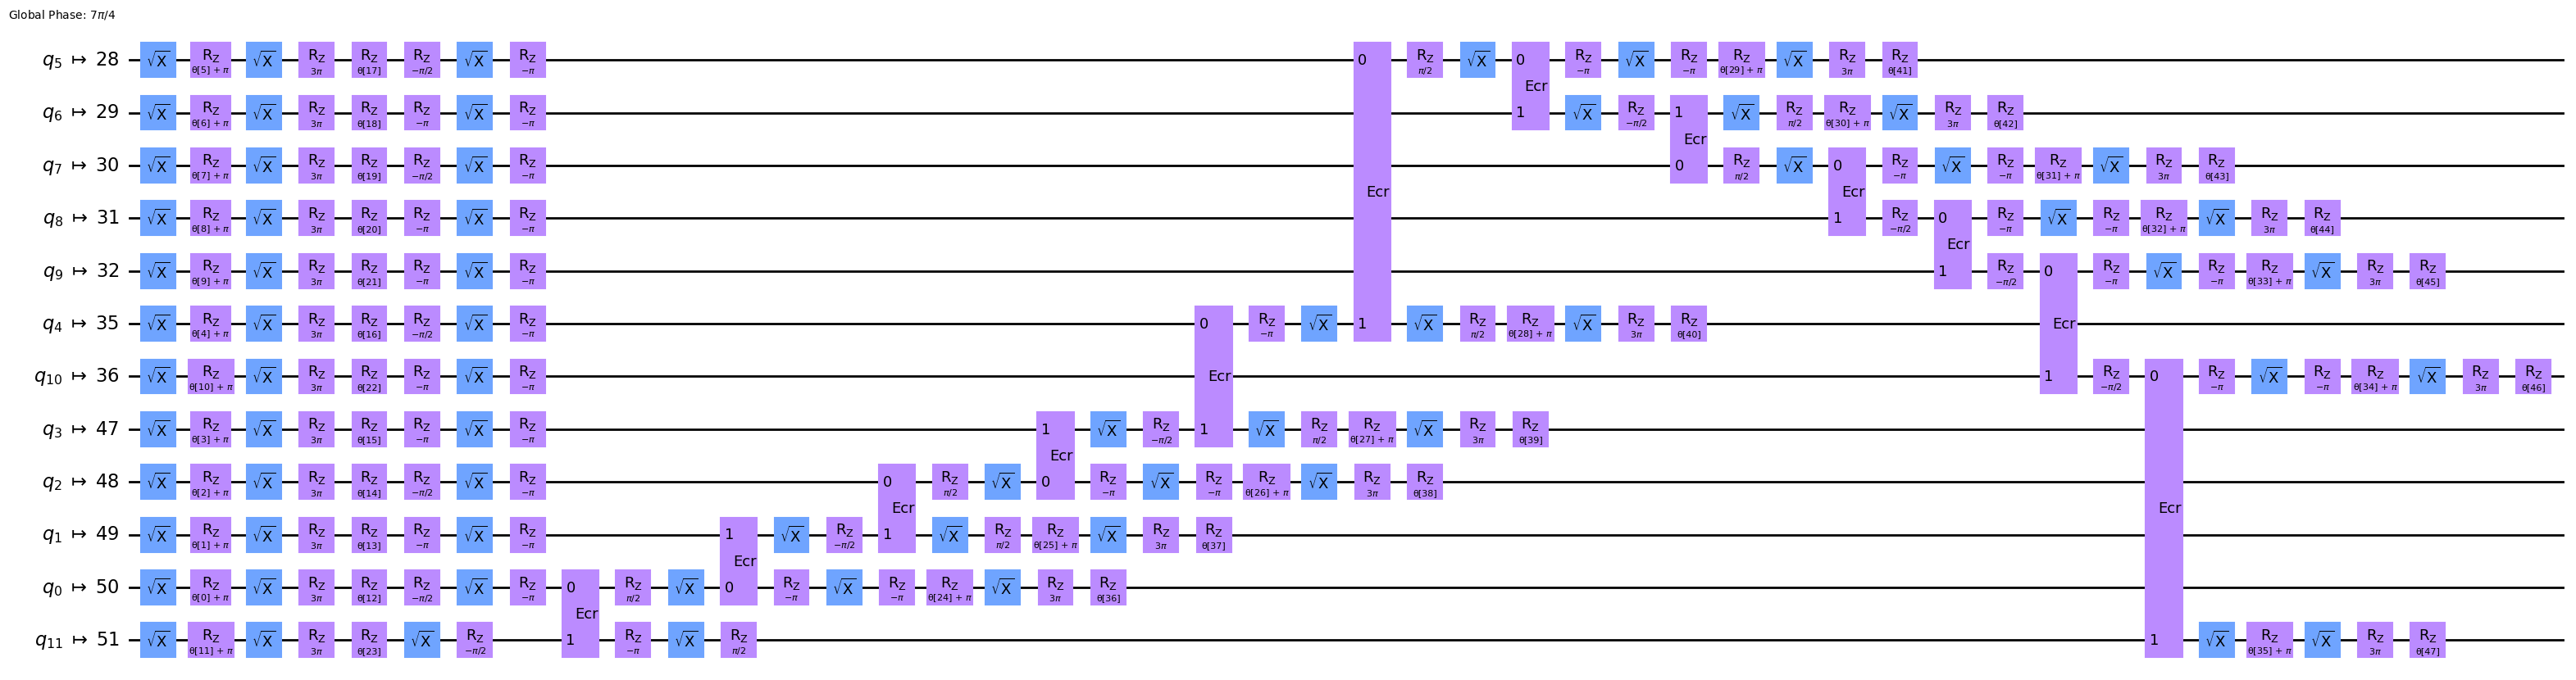

In [4]:
from qiskit import transpile
from qiskit.circuit.library import EfficientSU2

qc = EfficientSU2(12, entanglement="circular", reps=1)
qc_t = transpile(qc, target=target, seed_transpiler=12345)
qc_t.draw("mpl", style="iqp", fold=-1, idle_wires=False)

A _dynamical decoupling sequence_ is a series of gates that compose to the identity and are spaced regularly in time. They flip the qubits around the Bloch sphere which changes the effect of noise channels, therefore suppressing decoherence. For a full description, see [A Quantum Engineer's Guide to Superconducting Qubits](https://arxiv.org/abs/1904.06560). These are similar to refocusing pulses used in nuclear magnetic resonance. Here we'll create a simple sequence called XY4 consisting of four gates.

In [5]:
from qiskit.circuit.library import XGate, YGate

X = XGate()
Y = YGate()

dd_sequence = [X, Y, X, Y]

Because of the regular timing of dynamical decoupling sequences, we must add information about the `YGate` to the `target` because it is *not* a basis gate, whereas the `XGate` is. We know *a priori* that the `YGate` has the same duration and error as the `XGate`, however, so we can just retrieve those properties from the `target` and add them back for the `YGates`s. This is also why we needed to save the `basis_gates` separately, since we are adding the `YGate` instruction to the `target` although it is not an actual basis gate of `ibm_brisbane`.

In [6]:
from qiskit.transpiler import InstructionProperties

y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )

target.add_instruction(YGate(), y_gate_properties)

Ansatz circuits such as `EfficientSU2` are parameterized, so they much have value bound to them before being sent to the backend. Here we assign random parameters.

In [7]:
import numpy as np

rng = np.random.default_rng(1234)
qc_t.assign_parameters(rng.uniform(-np.pi, np.pi, qc_t.num_parameters), inplace=True)

Next, we execute the custom passes. We instantiate the `PassManager` with `ALAPScheduleAnalysis` and `PadDynamicalDecoupling`.  We must run `ALAPScheduleAnalysis` first to add timing information about the quantum circuit before the regularly-spaced dynamical decoupliong sequences can be added. These passes are run on the circuit with `.run()`.

In [8]:
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

dd_pm = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ]
)
qc_dd = dd_pm.run(qc_t)

We can use the visualization tool [`timeline_drawer`](/api/qiskit/qiskit.visualization.timeline_drawer) to see the circuit's timing and confirm that a regularly-spaced sequence of `XGate`s and `YGate`s appear in the circuit.

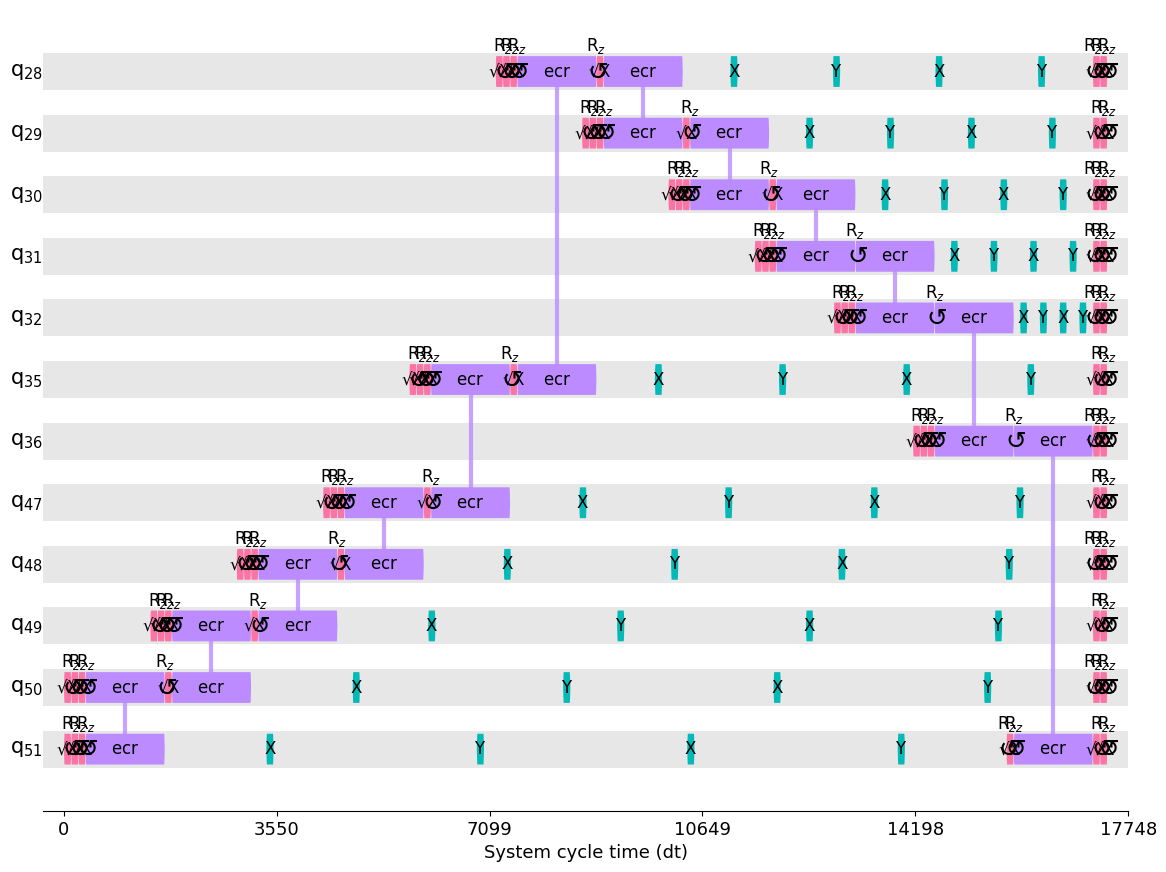

In [9]:
from qiskit.visualization import timeline_drawer

timeline_drawer(qc_dd, show_idle=False)

Lastly, because the `YGate` is not an actual basis gate of our backend, we must manually apply the `BasisTranslator` pass (this is a default pass, but it is executed before scheduling, so we need to apply it again). The session equivalence library is a library of circuit equivalences that allows the transpiler to decompose circuits into basis gates, as also specified as an argument.

/home/kjs/.local/share/virtualenvs/documentation--fuetTj0/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:282: UserWarning: Style JSON file 'iqp.json' not found in any of these locations: /home/kjs/.local/share/virtualenvs/documentation--fuetTj0/lib/python3.10/site-packages/qiskit/visualization/circuit/styles/iqp.json, iqp.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


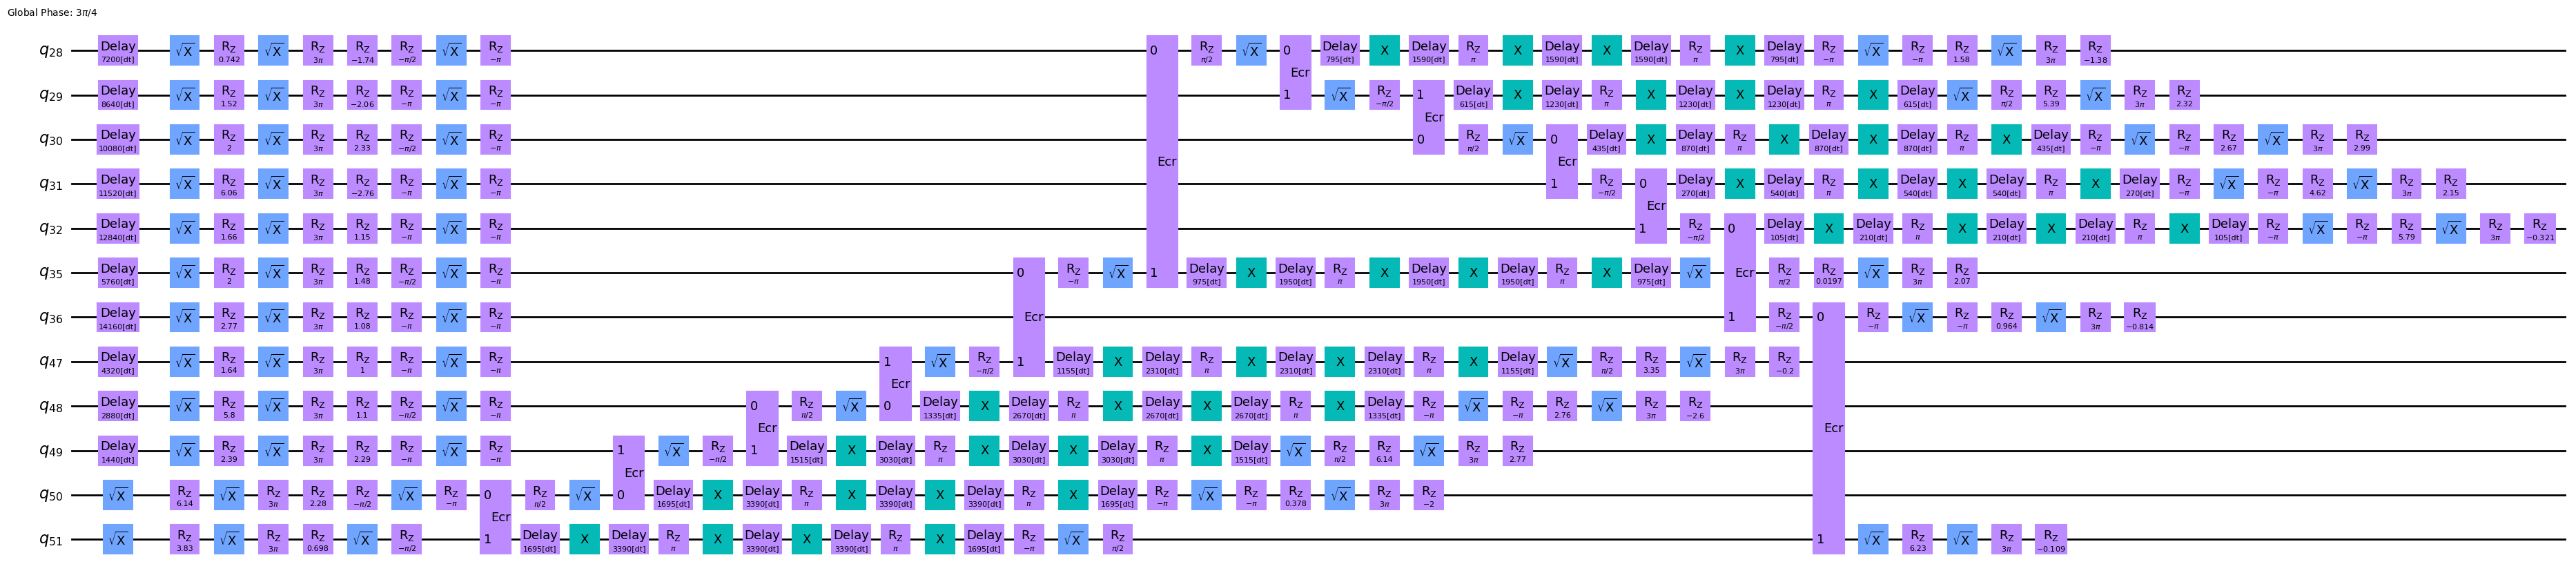

In [10]:
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel
from qiskit.transpiler.passes import BasisTranslator

qc_dd = BasisTranslator(sel, basis_gates)(qc_dd)
qc_dd.draw("mpl", style="iqp", fold=-1, idle_wires=False)

Now, `YGate`s are absent from our circuit, and we have explicit timing information in the form of `Delay` gates. This transpiled circuit with dynamical decoupling can now be sent to the backend.

## Creating your own staged pass manager

You can create a `StagedPassManager` simply by specifying the desired stages. For example, the following code creates a staged pass manager with two stages, `init` and `translation`. The `translation` stage is set to the pass manager that we created previously on this page.

In [11]:
from qiskit.transpiler import PassManager, StagedPassManager
from qiskit.transpiler.passes import UnitarySynthesis, Unroll3qOrMore

basis_gates = ["rx", "ry", "rxx"]
init = PassManager([UnitarySynthesis(basis_gates, min_qubits=3), Unroll3qOrMore()])
staged_pm = StagedPassManager(
    stages=["init", "translation"], init=init, translation=translate
)

There is no limit on the number of stages you can put in a staged pass manager.

Another useful way to create a staged pass manager is to begin with a preset passmanager and then swap out some of the stages. For example, the following code generates a preset pass manager with optimization level 3, and then specifies a custom `pre_layout` stage, and uses the dynamical decoupling pass we constructed earlier on this page for the `scheduling` stage.

In [12]:
from qiskit.circuit.library import HGate, PhaseGate, RXGate, TdgGate, TGate
from qiskit.transpiler.passes import CXCancellation, InverseCancellation

pass_manager = generate_preset_pass_manager(3, backend)
inverse_gate_list = [
    HGate(),
    (RXGate(np.pi / 4), RXGate(-np.pi / 4)),
    (PhaseGate(np.pi / 4), PhaseGate(-np.pi / 4)),
    (TGate(), TdgGate()),
]
logical_opt = PassManager(
    [
        CXCancellation(),
        InverseCancellation(inverse_gate_list),
    ]
)

# Add pre-layout stage to run extra logical optimization
pass_manager.pre_layout = logical_opt
# Set scheduling stage to custom pass manager
pass_manager.scheduling = dd_pm

The [stage generator functions](/api/qiskit/transpiler_preset#stage-generator-functions) functions may be useful for the construction of custom pass managers.
They generate stages which provide common functionality used in many pass managers.
For example, [`generate_embed_passmanager`](/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.common.generate_embed_passmanager) can be used to generate a stage
to "embed" a selected initial `Layout` from a layout pass to the specified target device.